In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb

In [20]:
train1DataFilename = 'spamTrain1.csv'
train2DataFilename = 'spamTrain2.csv'

data1 = np.loadtxt(train1DataFilename,delimiter=',')
data2 = np.loadtxt(train2DataFilename,delimiter=',')

data = np.r_[data1,data2]
X = data[:, :-1]
y = data[:, -1]


In [43]:
tpr_total_list = dict()
auc_total_list = dict()


In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from evaluateClassifier import tprAtFPR

desiredFPR = 0.01

from sklearn.feature_selection import RFE

num_trials = 50

for i in range(1, num_trials + 1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=i, stratify=y)

    imputer = SimpleImputer(missing_values=-1, strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    for n_features_to_select in range(10, 30):
        model = xgb.XGBClassifier(n_estimators=140, eval_metric='logloss', random_state=1)


        rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
        rfe = rfe.fit(X_train, y_train)



        # Transform the data to keep only selected features
        X_train_rfe = rfe.transform(X_train)
        X_test_rfe = rfe.transform(X_test)

        # Train the model on selected features
        model.fit(X_train_rfe, y_train)


        testOutputs = model.predict_proba(X_test_rfe)[:,1]

        aucTestRun = roc_auc_score(y_test,testOutputs)
        tprAtDesiredFPR,fpr,tpr = tprAtFPR(y_test,testOutputs, desiredFPR)

        if n_features_to_select not in tpr_total_list:
            tpr_total_list[n_features_to_select] = tprAtDesiredFPR
        else: 
            tpr_total_list[n_features_to_select] += tprAtDesiredFPR

        if n_features_to_select not in auc_total_list:
            auc_total_list[n_features_to_select] = aucTestRun
        else:
            auc_total_list[n_features_to_select] += aucTestRun

        plt.plot(fpr,tpr, label=f'{n_features_to_select} features')
        print(f'xgboost with {n_features_to_select} features | AUC: {aucTestRun} | TPR at FPR = {desiredFPR}: {tprAtDesiredFPR}')



    # plt.xlabel('False positive rate')
    # plt.ylabel('True positive rate')
    # plt.title('ROC curve for spam detector')
    # plt.legend()
    # plt.show()


In [45]:
auc_y = []
tpr_y = []

for n in auc_total_list.keys():
    auc_avg = auc_total_list[n] / num_trials
    tpr_avg = tpr_total_list[n] / num_trials

    auc_y.append(auc_avg)
    tpr_y.append(tpr_avg)

    print(f'features: {n} | auc_avg: {auc_avg} | tpr_avg: {tpr_avg}')

features: 10 | auc_avg: 0.8688920608950991 | tpr_avg: 0.34013500837520944
features: 11 | auc_avg: 0.8727077988688364 | tpr_avg: 0.34338458961474033
features: 12 | auc_avg: 0.8759678978131709 | tpr_avg: 0.3556448911222781
features: 13 | auc_avg: 0.878930755660918 | tpr_avg: 0.3640536013400335
features: 14 | auc_avg: 0.8827850400025228 | tpr_avg: 0.38314907872696824
features: 15 | auc_avg: 0.8847411104989698 | tpr_avg: 0.37919597989949744
features: 16 | auc_avg: 0.8862466262653246 | tpr_avg: 0.38170854271356786
features: 17 | auc_avg: 0.8867159347865201 | tpr_avg: 0.38070351758793974
features: 18 | auc_avg: 0.8870632045424612 | tpr_avg: 0.3788619765494138
features: 19 | auc_avg: 0.8871922365611744 | tpr_avg: 0.3899162479061976
features: 20 | auc_avg: 0.8868552433633653 | tpr_avg: 0.39011725293132327
features: 21 | auc_avg: 0.8864020174701487 | tpr_avg: 0.38391959798994973
features: 22 | auc_avg: 0.8860100428313585 | tpr_avg: 0.39118927973199324
features: 23 | auc_avg: 0.8865200865902046 

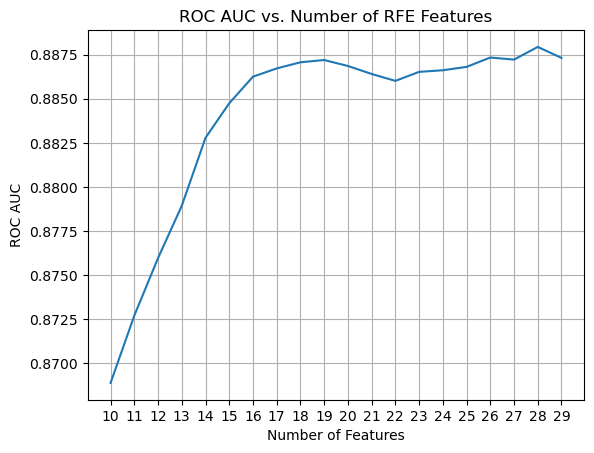

In [46]:
plt.plot(auc_total_list.keys(), auc_y)

plt.title('ROC AUC vs. Number of RFE Features')
plt.xlabel('Number of Features')
plt.ylabel('ROC AUC')

plt.grid(True)

plt.xticks(range(min(auc_total_list.keys()), max(auc_total_list.keys())+1))

plt.show()

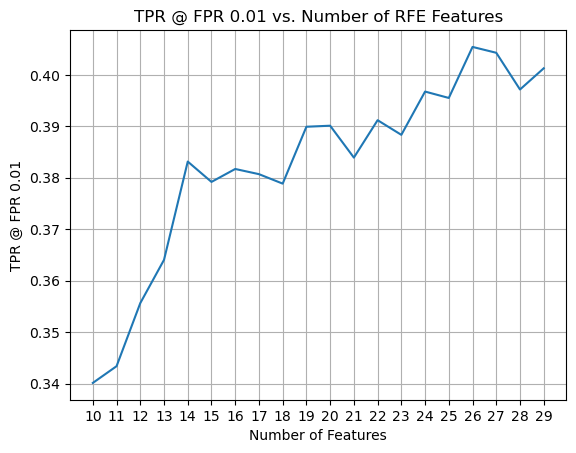

In [47]:
plt.plot(auc_total_list.keys(), tpr_y)

plt.title('TPR @ FPR 0.01 vs. Number of RFE Features')
plt.xlabel('Number of Features')
plt.ylabel('TPR @ FPR 0.01')

plt.grid(True)

plt.xticks(range(min(auc_total_list.keys()), max(auc_total_list.keys())+1))

plt.show()